**# Notebook Summary**
- Image Classifcation Model Trainer
- Model: MobileNetV3 - Small
- Classes:
    - Eichhornia Crassipes,
    - Hiptage Benghalensis,
    - Imperata Cylindrica,
    - Lantara Camara,
    - Leucaena Leucocephala,
    - Mikania Micrantha
- Paths:
    - Images: ../train_data/
    - Model: ../model.pt

In [18]:
# Package Mangement
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import copy

import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

In [19]:
# paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "../train_data")
MODEL_PATH = os.path.join(BASE_DIR, "model.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [20]:
# generators
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


class_names = full_dataset.classes

# 🔍 Count samples per class
from collections import Counter
class_counts = Counter([label for _, label in full_dataset.samples])

print("\nClass distribution:")
for idx, cls_name in enumerate(class_names):
    print(f"{cls_name:<20} {class_counts[idx]} images")

print(f"\nTotal images: {len(full_dataset)}")


Class distribution:
eichhornia_crassipes 676 images
hiptage_benghalensis 499 images
imperata_cylindrica  500 images
lantana_camara       507 images
mikania_micrantha    451 images

Total images: 2633


In [21]:
# model
model = models.mobilenet_v3_small(weights='DEFAULT')
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
EPOCHS = 20
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)
    
    # ---- Training ----
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Loss: {avg_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, MODEL_PATH)
        print(f" Best model updated (Accuracy: {best_acc:.2f}%)")

print("\nTraining complete.")
model.load_state_dict(best_model_wts)
print(f"Best validation accuracy: {best_acc:.2f}%")


Epoch 1/20
------------------------------


Loss: 1.0356 | Val Accuracy: 79.70%
 Best model updated (Accuracy: 79.70%)

Epoch 2/20
------------------------------


Loss: 0.5262 | Val Accuracy: 80.08%
 Best model updated (Accuracy: 80.08%)

Epoch 3/20
------------------------------


Loss: 0.3897 | Val Accuracy: 81.40%
 Best model updated (Accuracy: 81.40%)

Epoch 4/20
------------------------------


Loss: 0.3678 | Val Accuracy: 84.82%
 Best model updated (Accuracy: 84.82%)

Epoch 5/20
------------------------------


Loss: 0.2906 | Val Accuracy: 83.49%

Epoch 6/20
------------------------------


Loss: 0.2753 | Val Accuracy: 86.34%
 Best model updated (Accuracy: 86.34%)

Epoch 7/20
------------------------------


Loss: 0.2592 | Val Accuracy: 85.01%

Epoch 8/20
------------------------------


Loss: 0.2400 | Val Accuracy: 84.82%

Epoch 9/20
------------------------------


Loss: 0.2133 | Val Accuracy: 84.25%

Epoch 10/20
------------------------------


Loss: 0.2158 | Val Accuracy: 85.39%

Epoch 11/20
------------------------------


Loss: 0.2123 | Val Accuracy: 83.87%

Epoch 12/20
------------------------------


Loss: 0.1929 | Val Accuracy: 83.49%

Epoch 13/20
------------------------------


Loss: 0.1808 | Val Accuracy: 86.15%

Epoch 14/20
------------------------------


Loss: 0.1808 | Val Accuracy: 83.49%

Epoch 15/20
------------------------------


Loss: 0.1874 | Val Accuracy: 83.11%

Epoch 16/20
------------------------------


Loss: 0.1761 | Val Accuracy: 84.63%

Epoch 17/20
------------------------------


Loss: 0.1933 | Val Accuracy: 84.63%

Epoch 18/20
------------------------------


Loss: 0.1879 | Val Accuracy: 83.30%

Epoch 19/20
------------------------------


Loss: 0.1721 | Val Accuracy: 81.97%

Epoch 20/20
------------------------------


Loss: 0.1667 | Val Accuracy: 85.58%

Training complete.
Best validation accuracy: 86.34%


In [23]:
import json

LABELS_PATH = os.path.join(BASE_DIR, "class_labels.json")
with open(LABELS_PATH, "w") as f:
    json.dump(class_names, f)

print(f"Labels saved to {LABELS_PATH}")

Labels saved to /Users/mackenziecerenio/Developer/Python/invasive-plant-model/backend/models/class_labels.json


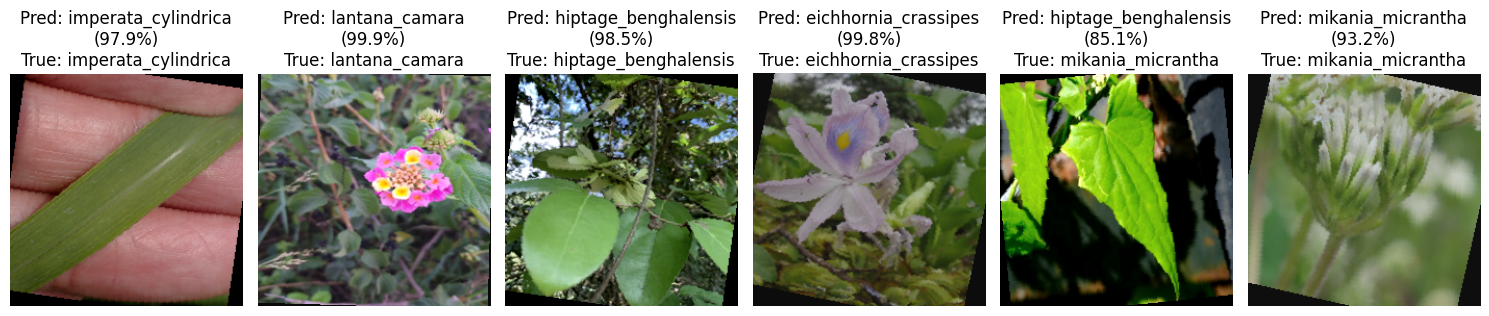

In [24]:
SAMPLE_COUNT = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper to show image ---
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# --- Randomly select samples from validation set ---
model.eval()
samples = random.sample(range(len(val_dataset)), SAMPLE_COUNT)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(samples):
    image, true_label = val_dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_class = torch.max(probs, 1)
    
    pred_label = class_names[pred_class.item()]
    confidence = conf.item() * 100
    true_label_name = class_names[true_label]
    
    plt.subplot(1, SAMPLE_COUNT, i + 1)
    title = f"Pred: {pred_label}\n({confidence:.1f}%)\nTrue: {true_label_name}"
    imshow(image.cpu(), title=title)

plt.tight_layout()
plt.show()
